# Bitcoin

In [531]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf
import plotly.graph_objects as go
from prophet import Prophet
from colorama import Fore
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#### Having a look at our data

In [461]:
# bitcoin = pd.read_csv('bitcoin_original.csv')
# bitcoin = bitcoin.drop(columns=['Unnamed: 0'])
# for name in bitcoin.columns[1:-2]:
#     bitcoin[name] = bitcoin[name].str.replace(',', '').astype(float)
# bitcoin['Date'] = pd.to_datetime(bitcoin['Date'], format='%m/%d/%Y').dt.strftime('%Y-%m-%d')
# bitcoin = bitcoin.sort_values('Date')
# bitcoin['Average'] = (bitcoin['High'] + bitcoin['Low']) / 2
# bitcoin['Date'] = pd.to_datetime(bitcoin['Date'])
# bitcoin.head()

In [462]:
bitcoin_data = pd.read_csv('data/bitcoin/bitcoin_preprocessed.csv', parse_dates=['Date'])

In [463]:
bitcoin_data.head()

Date  Price  Open  High  Low   Vol. Change %  Average
0 2010-07-18    0.1   0.0   0.1  0.1  0.08K    0.00%      0.1
1 2010-07-19    0.1   0.1   0.1  0.1  0.57K    0.00%      0.1
2 2010-07-20    0.1   0.1   0.1  0.1  0.26K    0.00%      0.1
3 2010-07-21    0.1   0.1   0.1  0.1  0.58K    0.00%      0.1
4 2010-07-22    0.1   0.1   0.1  0.1  2.16K    0.00%      0.1

In [464]:
bitcoin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      5282 non-null   datetime64[ns]
 1   Price     5282 non-null   float64       
 2   Open      5282 non-null   float64       
 3   High      5282 non-null   float64       
 4   Low       5282 non-null   float64       
 5   Vol.      5276 non-null   object        
 6   Change %  5282 non-null   object        
 7   Average   5282 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 330.3+ KB


In [465]:
bitcoin_data.describe()

Date          Price           Open           High  \
count                 5282    5282.000000    5282.000000    5282.000000   
mean   2017-10-09 12:00:00   13991.793601   13973.960621   14301.911473   
min    2010-07-18 00:00:00       0.100000       0.000000       0.100000   
25%    2014-02-27 06:00:00     236.325000     236.225000     240.300000   
50%    2017-10-09 12:00:00    3694.250000    3688.400000    3826.400000   
75%    2021-05-21 18:00:00   20759.675000   20725.975000   21307.025000   
max    2025-01-01 00:00:00  106138.900000  106140.700000  108244.900000   
std                    NaN   20663.596560   20634.796513   21096.208461   

                 Low        Average  
count    5282.000000    5282.000000  
mean    13630.541746   13966.226609  
min         0.000000       0.050000  
25%       232.325000     236.250000  
50%      3611.800000    3727.825000  
75%     20256.025000   20796.437500  
max    105350.600000  106797.750000  
std     20162.686270   20626.123003

In [466]:
bitcoin_data.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        6
Change %    0
Average     0
dtype: int64

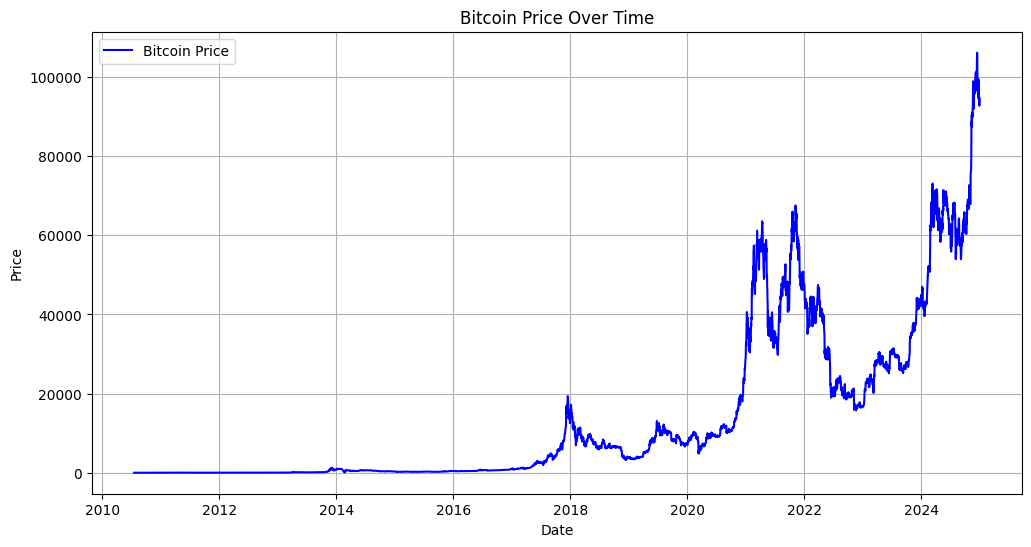

In [467]:
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_data['Date'], bitcoin_data['Price'], label='Bitcoin Price', color='blue')
plt.title('Bitcoin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [468]:
fig = go.Figure(data=[go.Candlestick(x=bitcoin_data.index,
                                     open=bitcoin_data['Open'],
                                     high=bitcoin_data['High'],
                                     low=bitcoin_data['Low'],
                                     close=bitcoin_data['Price'])])
fig.update_layout(title='Bitcoin Candlestick Chart', yaxis_title='Price (USD)')
fig.show()

#### Graphing Bitcoin Halving events

When Is the Next Bitcoin Halving?

Nov. 28, 2012, to 25 bitcoins.

July 9, 2016, to 12.5 bitcoins.

May 11, 2020, to 6.25 bitcoins.

April 19, 2024, to 3.125 bitcoins.

<figure>
  <img src="data/bitcoin/bitcoin_halving.webp" alt="Bitcoin Halving" width="600">
  <figcaption>Source: [Bitcoin Halving: What It Is and Why It Matters for Crypto Investors](https://www.investopedia.com/bitcoin-halving-4843769)</figcaption>
</figure>


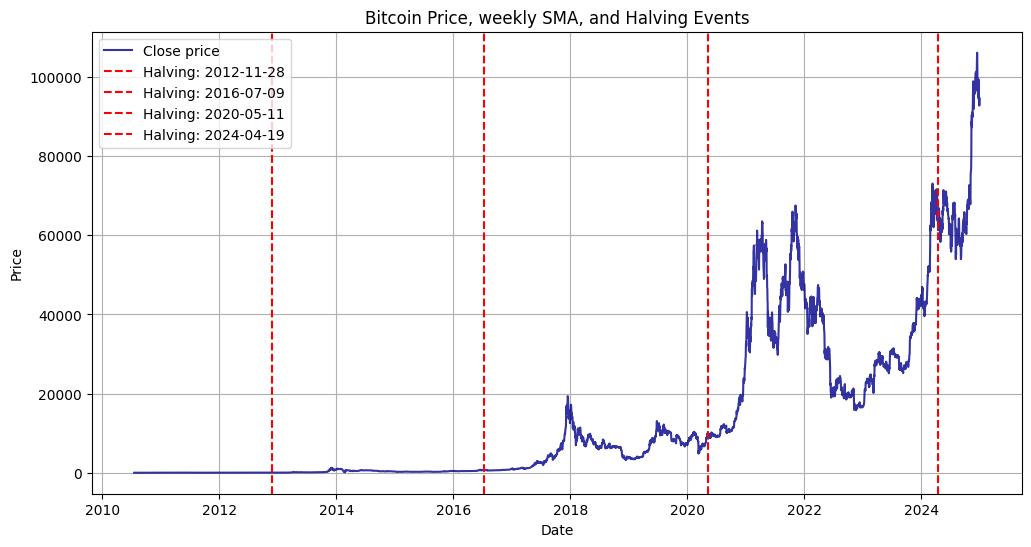

In [469]:
halving_dates = pd.to_datetime(['2012-11-28', '2016-07-09', '2020-05-11', '2024-04-19'])
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_data["Date"], bitcoin_data["Price"], label='Close price', color='darkblue', alpha=0.8)

for halving_date in halving_dates:
    plt.axvline(x=halving_date, color='red', linestyle='--', label=f'Halving: {halving_date.strftime("%Y-%m-%d")}')
plt.title('Bitcoin Price, weekly SMA, and Halving Events')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


<span style="font-size: 32px; font-weight: bold;">!!!!!!!!!!!!! From now on we are only using data from 2016 onwards !!!!!!!!!!!!!</span>


In [470]:
bitcoin_data.columns


Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'Average'], dtype='object')

In [471]:
columns_to_drop = ['Open', 'High', 'Low', 'Vol.', 'Change %', 'Average']
bitcoin = bitcoin_data.drop(columns=columns_to_drop)
bitcoin = bitcoin[bitcoin['Date'] >= '2016-01-01']
bitcoin = bitcoin.set_index('Date')
bitcoin

Price
Date               
2016-01-01    434.0
2016-01-02    433.7
2016-01-03    430.7
2016-01-04    433.3
2016-01-05    431.2
...             ...
2024-12-28  95284.5
2024-12-29  93716.3
2024-12-30  92779.8
2024-12-31  93557.2
2025-01-01  94560.2

[3289 rows x 1 columns]

#### Stationarity check - Augmented Dickey–Fuller test and seasonality checks

In [472]:
adf_test = adfuller(bitcoin['Price'])
print("ADF statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical values:", adf_test[4])

if adf_test[1] < 0.05:
    print("Reject the null hypothesis - series is stationary")
else:
    print("Fail to reject the null hypothesis - series is non-stationary")

ADF statistic: -0.029257087001064667
p-value: 0.9560446238021381
Critical values: {'1%': np.float64(-3.4323581184837426), '5%': np.float64(-2.862427266935068), '10%': np.float64(-2.5672423111140947)}
Fail to reject the null hypothesis - series is non-stationary


#### Why Create `Close_Diff`, `Close_Log`, and `Close_Log_Diff` columns?

When analyzing and modeling non-stationary time series data, such as Bitcoin prices, it is important to transform the data into a stationary form. Stationarity means that the statistical properties of the series (mean, variance) do not change over time, which is a key assumption for many time series models. We create the following three columns to address this:

1. `Close_Diff` (Differencing)
- **Purpose**: To stabilize the mean of the series by removing trends.
- **Explanation**: Differencing subtracts each data point from the previous one, helping to eliminate trends and making the series stationary. This is essential for models that require constant mean and variance over time.

2. `Close_Log` (Logging)
- **Purpose**: To stabilize the variance of the series.
- **Explanation**: Logging reduces the impact of large fluctuations by compressing the scale of the data. This is especially useful when the series exhibits exponential growth or large spikes, as it makes the data more consistent and easier to analyze.

3. `Close_Log_Diff` (Logging followed by Differencing)
- **Purpose**: To handle both non-stationary mean and variance simultaneously.
- **Explanation**: Logging is applied first to stabilize the variance, followed by differencing to stabilize the mean. This combination ensures the series meets the stationarity requirements, making it suitable for decomposition and predictive modeling.

Importance of These Transformations
- **Stationarity Requirement**: Many time series models, such as ARIMA, assume that the data is stationary. These transformations help meet that requirement, ensuring the models can accurately capture and predict patterns in the data.
- **Component Separation**: By transforming the series, we can more effectively separate the trend, seasonal, and residual components, leading to a clearer understanding of the underlying patterns.
- **Improved Model Accuracy**: Stationary series often result in more reliable and accurate models, as they align better with the assumptions of common time series analysis techniques.

#### Creating new columns

In [473]:
bitcoin['Close_Diff'] = bitcoin['Price'].diff()
bitcoin['Close_Log'] = np.log(bitcoin['Price'])
bitcoin['Close_Log_Diff'] = bitcoin['Close_Log'].diff()

In [474]:
bitcoin.head()

Price  Close_Diff  Close_Log  Close_Log_Diff
Date                                                    
2016-01-01  434.0         NaN   6.073045             NaN
2016-01-02  433.7        -0.3   6.072353       -0.000691
2016-01-03  430.7        -3.0   6.065412       -0.006941
2016-01-04  433.3         2.6   6.071430        0.006019
2016-01-05  431.2        -2.1   6.066572       -0.004858

Drop the NaN values created by differencing

In [475]:
bitcoin.dropna(subset=['Close_Diff', 'Close_Log', 'Close_Log_Diff'], inplace=True)
bitcoin.head()

Price  Close_Diff  Close_Log  Close_Log_Diff
Date                                                    
2016-01-02  433.7        -0.3   6.072353       -0.000691
2016-01-03  430.7        -3.0   6.065412       -0.006941
2016-01-04  433.3         2.6   6.071430        0.006019
2016-01-05  431.2        -2.1   6.066572       -0.004858
2016-01-06  430.8        -0.4   6.065644       -0.000928

In [476]:
bitcoin.tail()

Price  Close_Diff  Close_Log  Close_Log_Diff
Date                                                      
2024-12-28  95284.5      1008.6  11.464622        0.010642
2024-12-29  93716.3     -1568.2  11.448027       -0.016595
2024-12-30  92779.8      -936.5  11.437984       -0.010043
2024-12-31  93557.2       777.4  11.446328        0.008344
2025-01-01  94560.2      1003.0  11.456992        0.010664

In [477]:
series_list = {
    'Close_Diff': bitcoin['Close_Diff'],
    'Close_Log': bitcoin['Close_Log'],
    'Close_Log_Diff': bitcoin['Close_Log_Diff']
}

for label, series in series_list.items():
    adf_test = adfuller(series)
    adf_p_value = adf_test[1]
    if adf_p_value < 0.05:
        print(f"{label} is stationary, with p-value: {adf_p_value}")
    else:
        print(f"{label} is non-stationary, with p-value: {adf_p_value}")

Close_Diff is stationary, with p-value: 2.3136336478386594e-15
Close_Log is non-stationary, with p-value: 0.4834741731268842
Close_Log_Diff is stationary, with p-value: 0.0


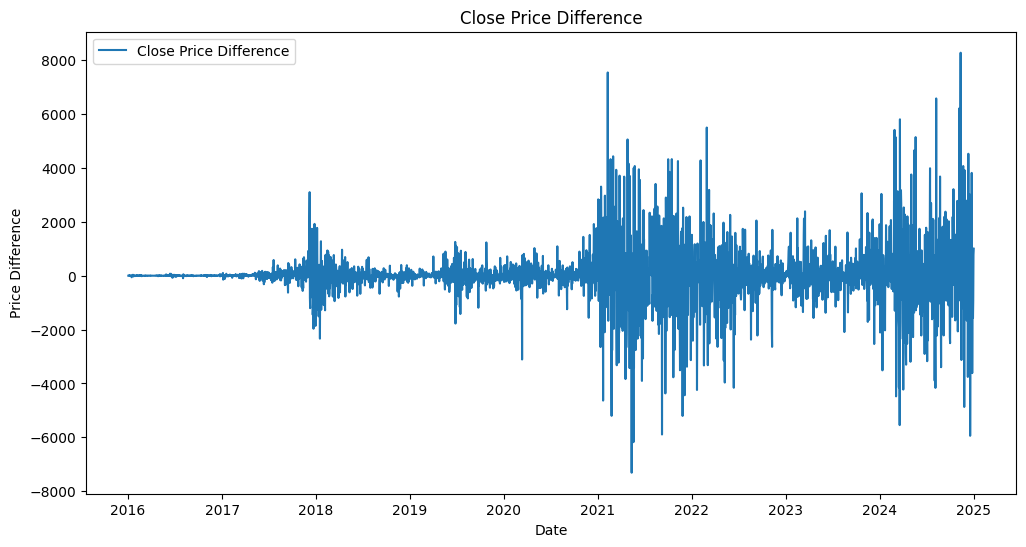

In [478]:
plt.figure(figsize=(12, 6))
plt.plot(bitcoin['Close_Diff'], label='Close Price Difference')
plt.title('Close Price Difference')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.legend()
plt.show()

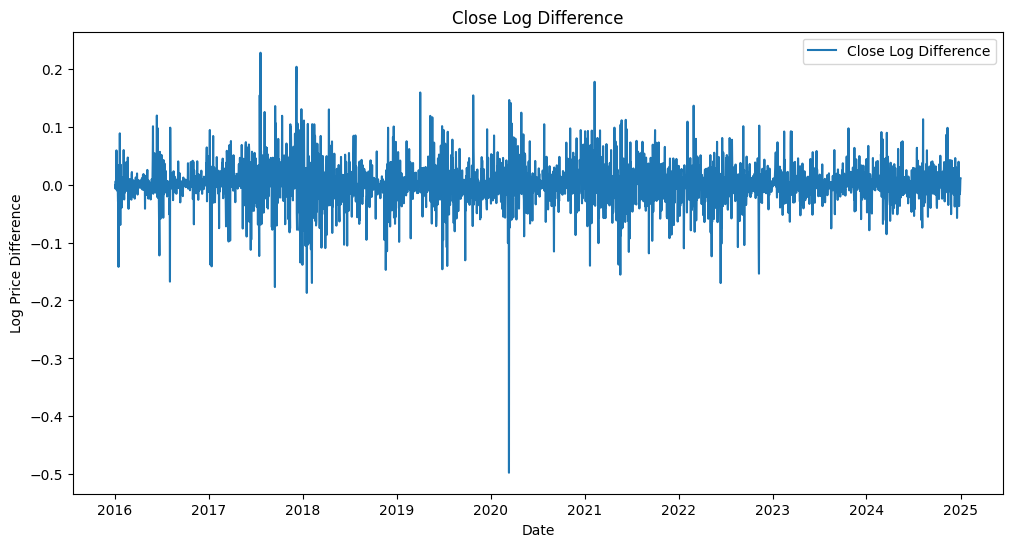

In [479]:
plt.figure(figsize=(12, 6))
plt.plot(bitcoin['Close_Log_Diff'], label='Close Log Difference')
plt.title('Close Log Difference')
plt.xlabel('Date')
plt.ylabel('Log Price Difference')
plt.legend()
plt.show()

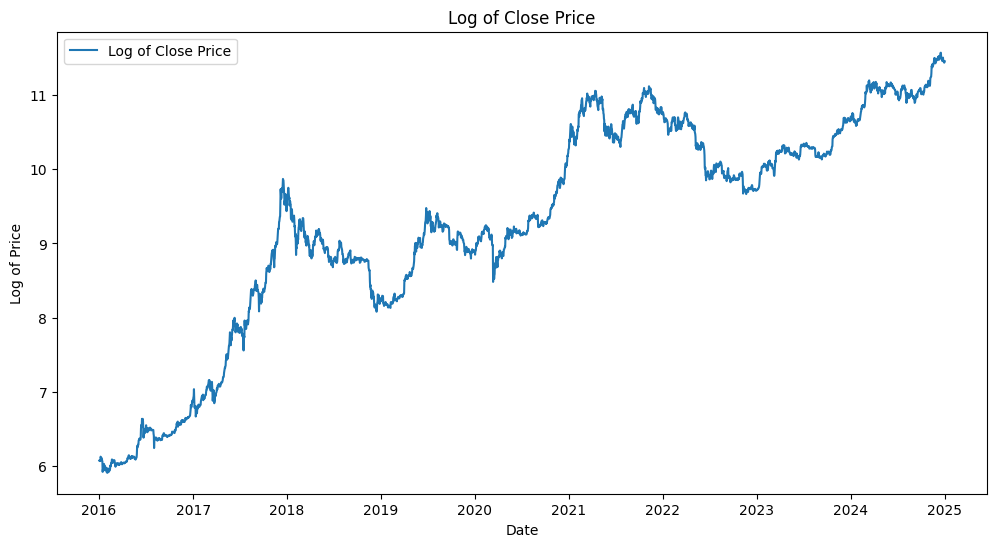

In [480]:
plt.figure(figsize=(12, 6))
plt.plot(bitcoin['Close_Log'], label='Log of Close Price')
plt.title('Log of Close Price')
plt.xlabel('Date')
plt.ylabel('Log of Price')
plt.legend()
plt.show()

#### Plotting frequency

In [481]:
df_monthly = bitcoin.resample('ME').mean()
df_annual = bitcoin.resample('YE').mean()
df_quarterly = bitcoin.resample('QE').mean()

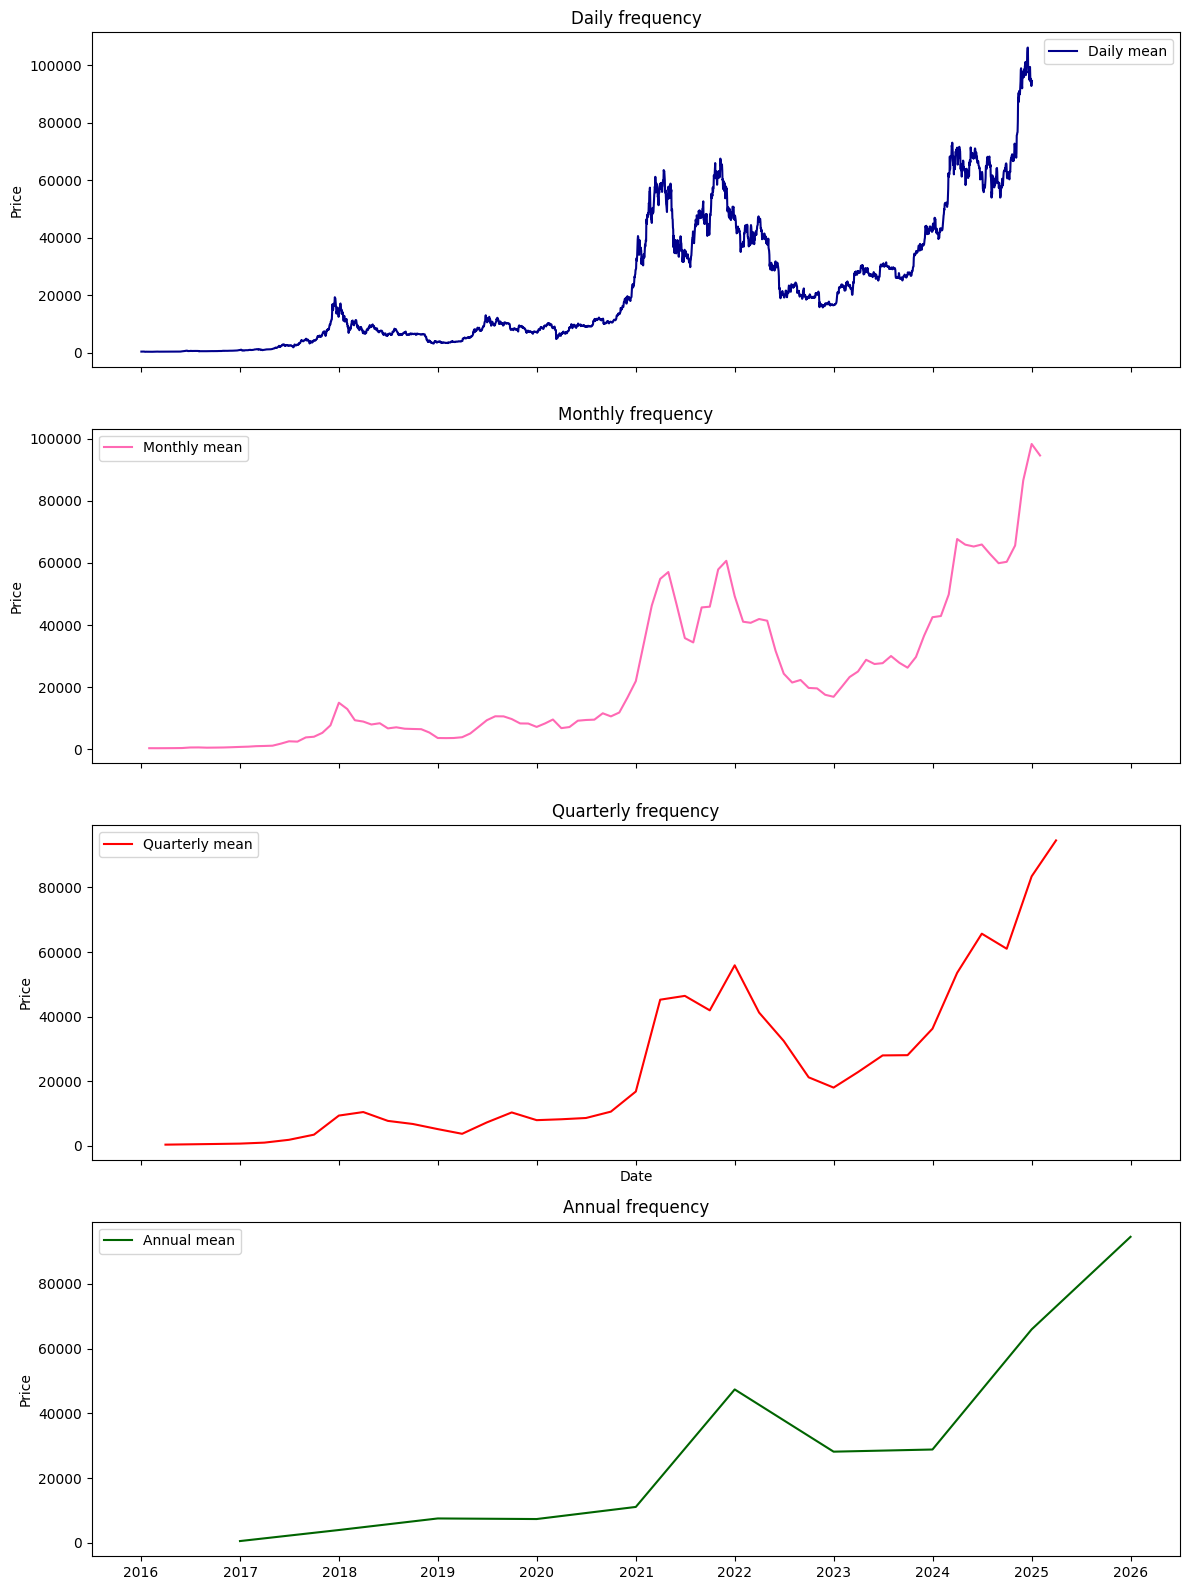

In [482]:
fig, axs = plt.subplots(4, 1, figsize=(12, 16), sharex=True)
axs[0].plot(bitcoin.index, bitcoin['Price'], label='Daily mean', color='darkblue')
axs[0].set_title('Daily frequency')
axs[0].set_ylabel('Price')
axs[0].legend()

axs[1].plot(df_monthly.index, df_monthly['Price'], label='Monthly mean', color='hotpink')
axs[1].set_title('Monthly frequency')
axs[1].set_ylabel('Price')
axs[1].legend()

axs[2].plot(df_quarterly.index, df_quarterly['Price'], label='Quarterly mean', color='red')
axs[2].set_title('Quarterly frequency')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Price')
axs[2].legend()

axs[3].plot(df_annual.index, df_annual['Price'], label='Annual mean', color='darkgreen')
axs[3].set_title('Annual frequency')
axs[3].set_ylabel('Price')
axs[3].legend()

plt.tight_layout()
plt.show()

#### Moving Average

In [483]:
bitcoin['SMA_7'] = bitcoin['Price'].rolling(window=7).mean()
bitcoin_data['SMA_7'] = bitcoin_data['Price'].rolling(window=7).mean()
bitcoin.head(15)


Price  Close_Diff  Close_Log  Close_Log_Diff       SMA_7
Date                                                                
2016-01-02  433.7        -0.3   6.072353       -0.000691         NaN
2016-01-03  430.7        -3.0   6.065412       -0.006941         NaN
2016-01-04  433.3         2.6   6.071430        0.006019         NaN
2016-01-05  431.2        -2.1   6.066572       -0.004858         NaN
2016-01-06  430.8        -0.4   6.065644       -0.000928         NaN
2016-01-07  457.0        26.2   6.124683        0.059039         NaN
2016-01-08  452.9        -4.1   6.115671       -0.009012  438.514286
2016-01-09  448.3        -4.6   6.105463       -0.010209  440.600000
2016-01-10  446.2        -2.1   6.100767       -0.004695  442.814286
2016-01-11  447.7         1.5   6.104123        0.003356  444.871429
2016-01-12  445.0        -2.7   6.098074       -0.006049  446.842857
2016-01-13  432.2       -12.8   6.068888       -0.029186  447.042857
2016-01-14  429.1        -3.1   6.061690       -0.007198  443.057143
2016-01-15  372.3       -56.8   5.919700       -0.141990  431.542857
2016-01-16  385.0        12.7   5.953243        0.033543  422.500000

In [484]:
bitcoin.tail()


Price  Close_Diff  Close_Log  Close_Log_Diff         SMA_7
Date                                                                    
2024-12-28  95284.5      1008.6  11.464622        0.010642  96204.771429
2024-12-29  93716.3     -1568.2  11.448027       -0.016595  95995.128571
2024-12-30  92779.8      -936.5  11.437984       -0.010043  95699.085714
2024-12-31  93557.2       777.4  11.446328        0.008344  94968.957143
2025-01-01  94560.2      1003.0  11.456992        0.010664  94278.800000

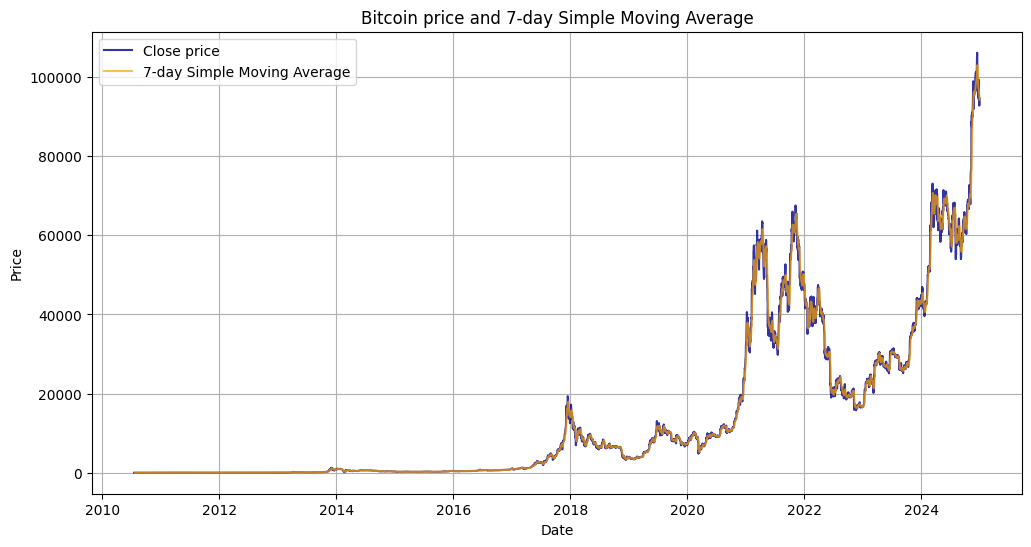

In [485]:
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_data["Date"], bitcoin_data["Price"], label='Close price', color='darkblue', alpha=0.8)
plt.plot(bitcoin_data["Date"], bitcoin_data['SMA_7'], label='7-day Simple Moving Average', color='orange', alpha=0.7)
plt.title('Bitcoin price and 7-day Simple Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


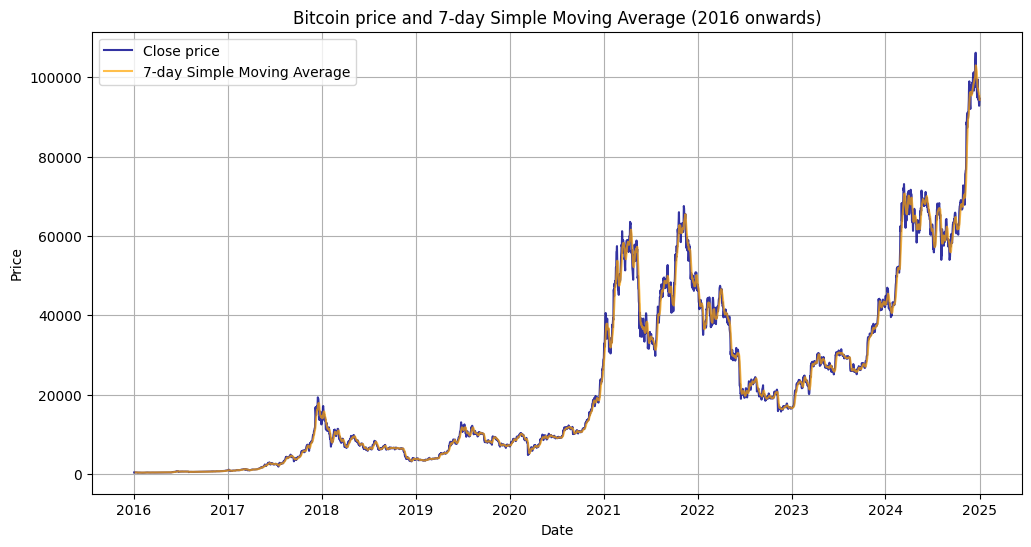

In [486]:
plt.figure(figsize=(12, 6))
plt.plot(bitcoin["Price"], label='Close price', color='darkblue', alpha=0.8)
plt.plot(bitcoin['SMA_7'], label='7-day Simple Moving Average', color='orange', alpha=0.7)
plt.title('Bitcoin price and 7-day Simple Moving Average (2016 onwards)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

#### Plotting decompositions

1. **Original Time Series: Multiplicative Decomposition**
- **Reason**: The original series is non-stationary (due to trends and high volatility). 
- **Why Multiplicative?**: Multiplicative decomposition is used when seasonality scales with the level of the series. Bitcoin's volatility and trends make this model suitable.

2. **Differenced Time Series: Additive Decomposition**
- **Reason**: Differencing removes the trend, making the series stationary with constant mean and variance.
- **Why Additive?**: Additive decomposition assumes the series has constant variance, which fits the differenced series after it’s been made stationary.

3. **Logged Time Series: Additive Decomposition**
- **Reason**: Logging stabilizes variance but does not always make the series stationary.
- **Why Additive?**: Even though the series is still non-stationary, logging helps reduce fluctuations, and additive decomposition fits better for the stationary-like behavior of the logged series.

4. **Logged and Differenced Time Series: Additive Decomposition**
- **Reason**: Logging followed by differencing removes both trends and stabilizes the variance, making the series stationary.
- **Why Additive?**: Since the series is now stationary, additive decomposition works best as the seasonal and residual components are now stable.


In [487]:
def plot_decomposition(series, model, period, title, plot_color):
    decomposition = seasonal_decompose(series, model=model, period=period)
    fig = decomposition.plot()
    fig.set_size_inches(10, 8)
    plt.suptitle(title, fontsize=16)
    fig.patch.set_facecolor(plot_color)
    plt.show()

##### Yearly

In [488]:
def plot_decomposition(series, model, period, title, plot_color):
    decomposition = seasonal_decompose(series, model=model, period=period)
    fig = decomposition.plot()
    fig.set_size_inches(10, 8)
    plt.suptitle(title, fontsize=16)
    for ax in fig.axes:
        for line in ax.get_lines():
            line.set_color(plot_color)
    plt.show()

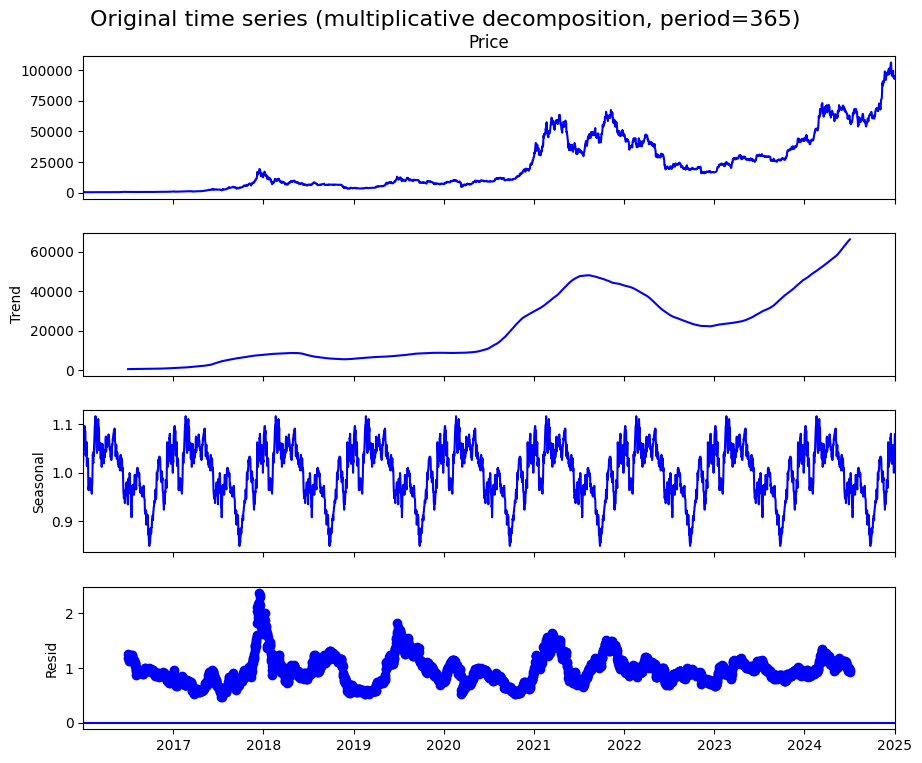

In [489]:
plot_decomposition(bitcoin['Price'], model='multiplicative', period=365, title="Original time series (multiplicative decomposition, period=365)", plot_color='blue')

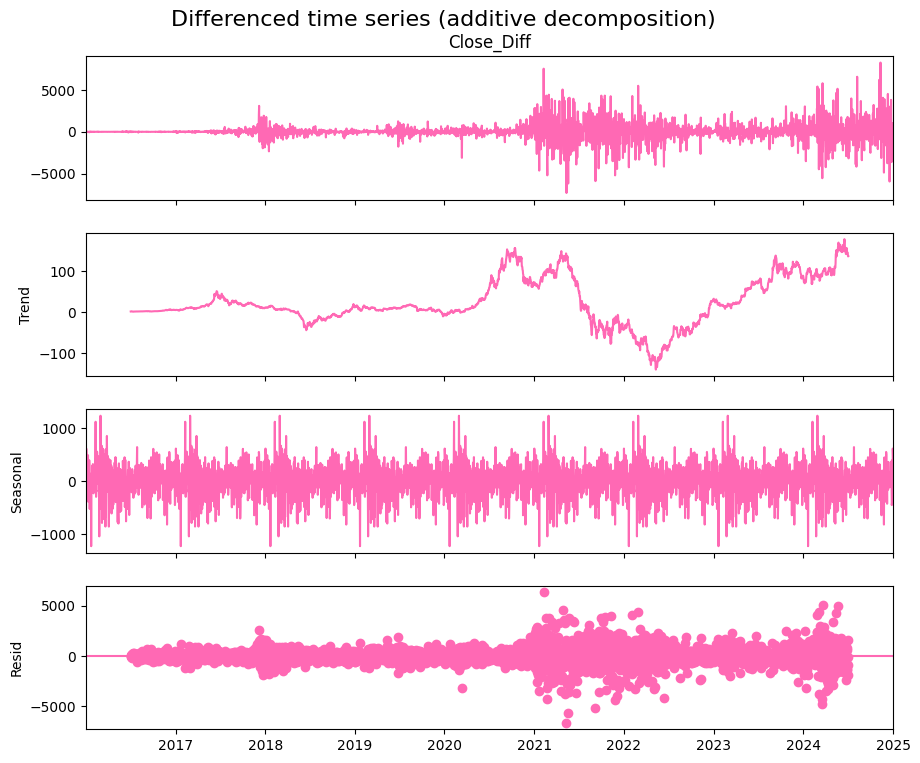

In [490]:
plot_decomposition(bitcoin['Close_Diff'], model='additive',period=365, plot_color='hotpink', title="Differenced time series (additive decomposition)")


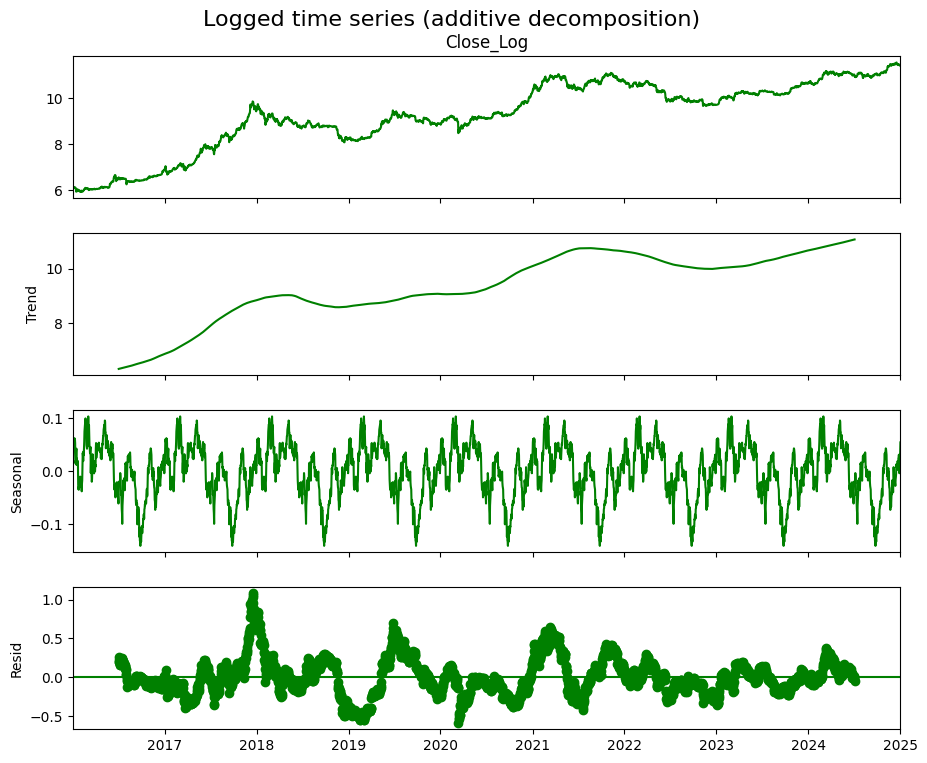

In [491]:
plot_decomposition(bitcoin['Close_Log'], model='additive', period=365, title="Logged time series (additive decomposition)", plot_color='green')


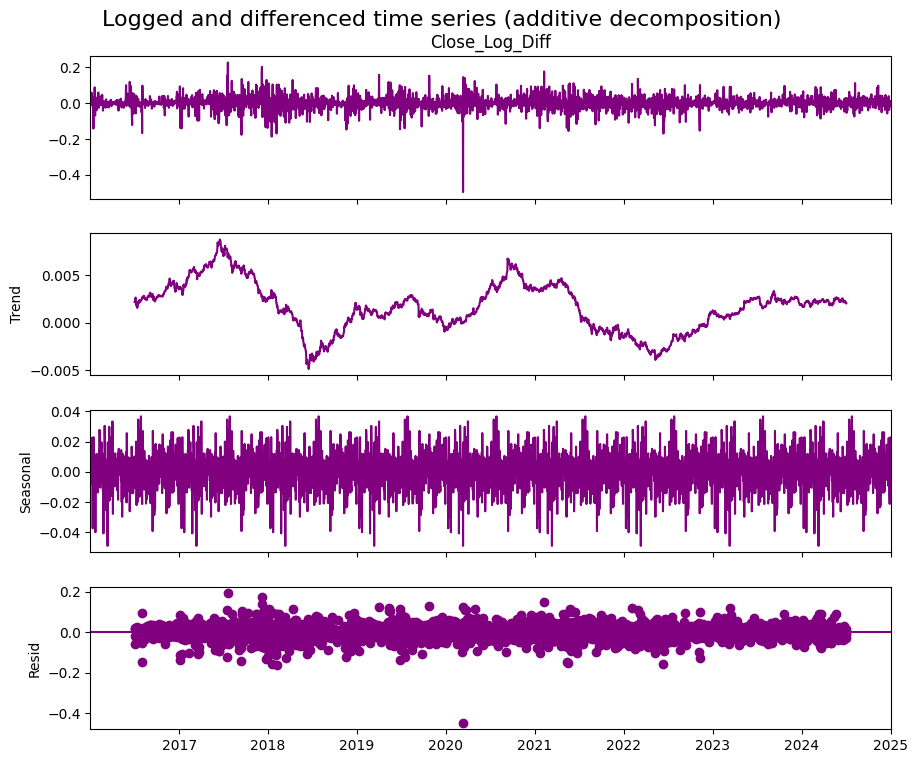

In [492]:
plot_decomposition(bitcoin['Close_Log_Diff'], model='additive', period=365, title="Logged and differenced time series (additive decomposition)", plot_color='purple')


##### Quarterly

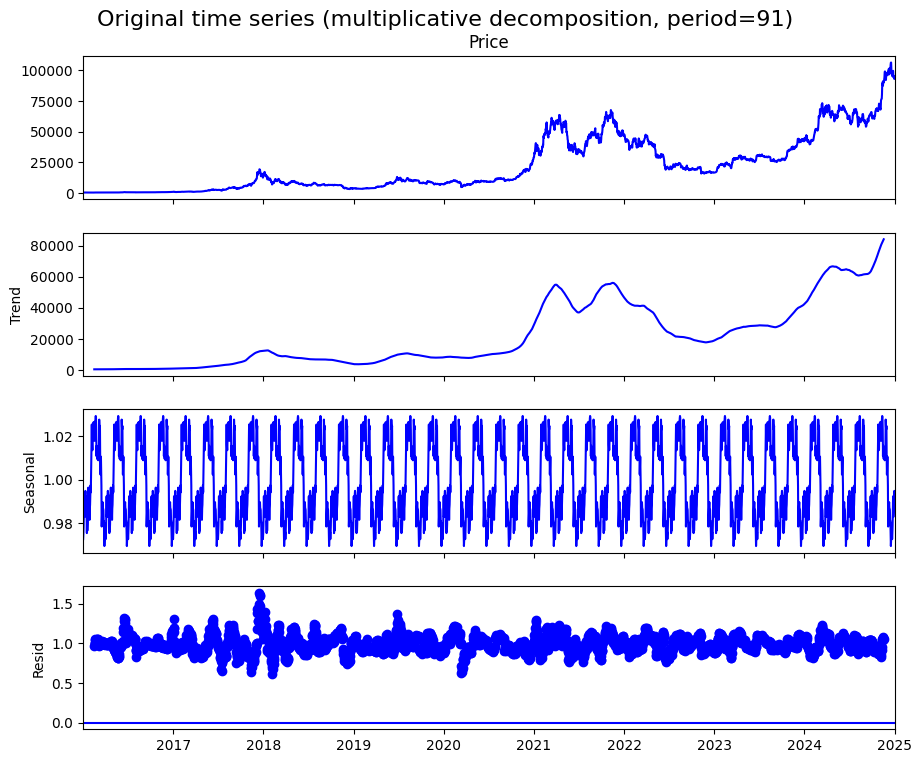

In [493]:
plot_decomposition(bitcoin['Price'], model='multiplicative', period=91, title="Original time series (multiplicative decomposition, period=91)", plot_color='blue')


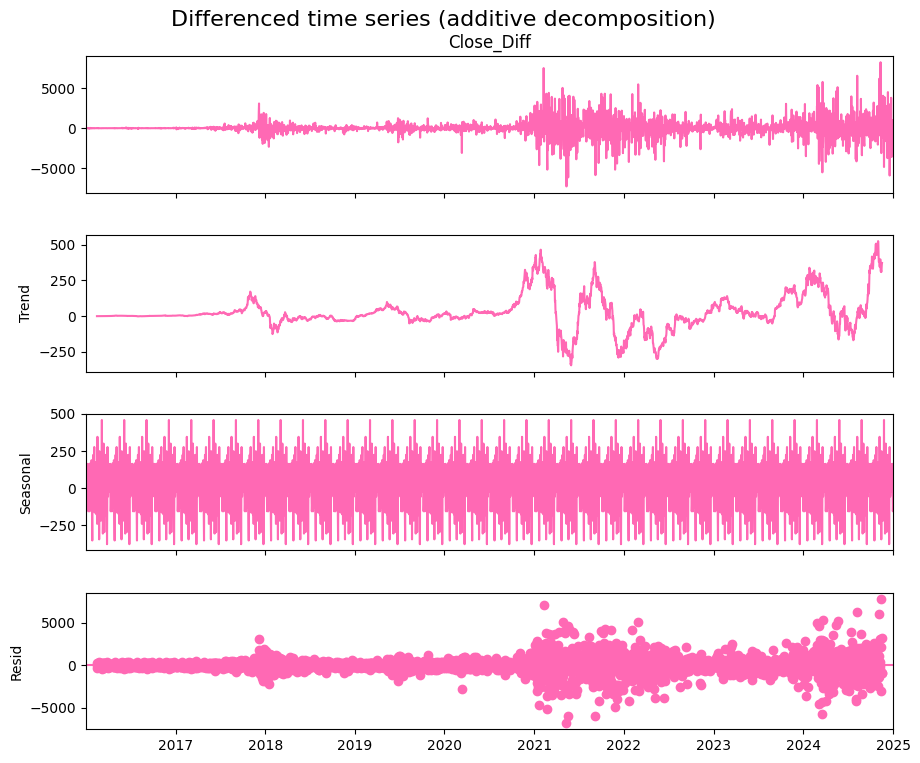

In [494]:
plot_decomposition(bitcoin['Close_Diff'], model='additive', period=91, title="Differenced time series (additive decomposition)", plot_color='hotpink')

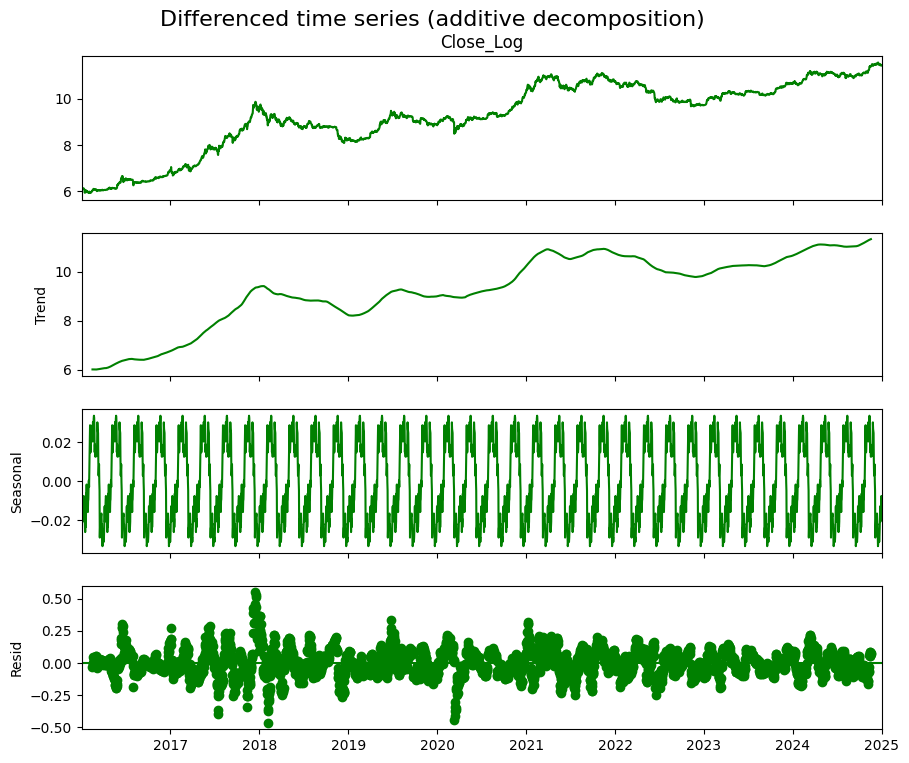

In [495]:
plot_decomposition(bitcoin['Close_Log'], model='additive', period=91, title="Differenced time series (additive decomposition)", plot_color='green')

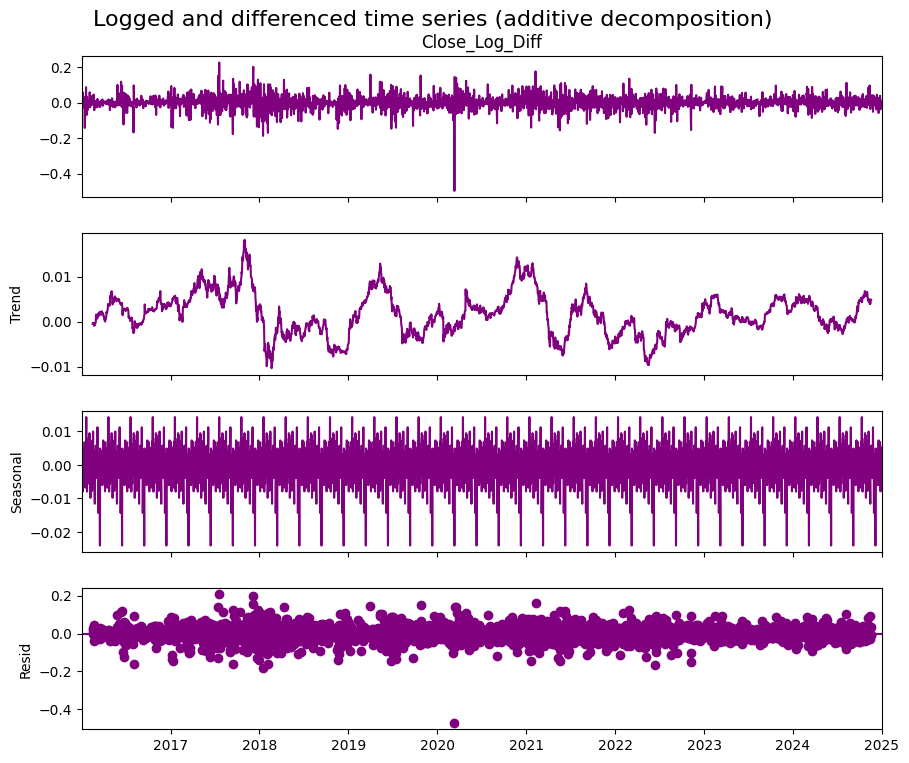

In [496]:
plot_decomposition(bitcoin['Close_Log_Diff'], model='additive', period=91, title="Logged and differenced time series (additive decomposition)", plot_color='purple')


##### 4-year periods

In [497]:
halving_periods = [
    {'start': '2016-07-09', 'end': '2020-05-11'},  # From first to second halving
    {'start': '2020-05-11', 'end': '2024-04-19'},  # From second to third halving
]

halving_data = []
for period in halving_periods:
    segment = bitcoin[(bitcoin.index >= period['start']) & (bitcoin.index <= period['end'])]
    halving_data.append(segment)

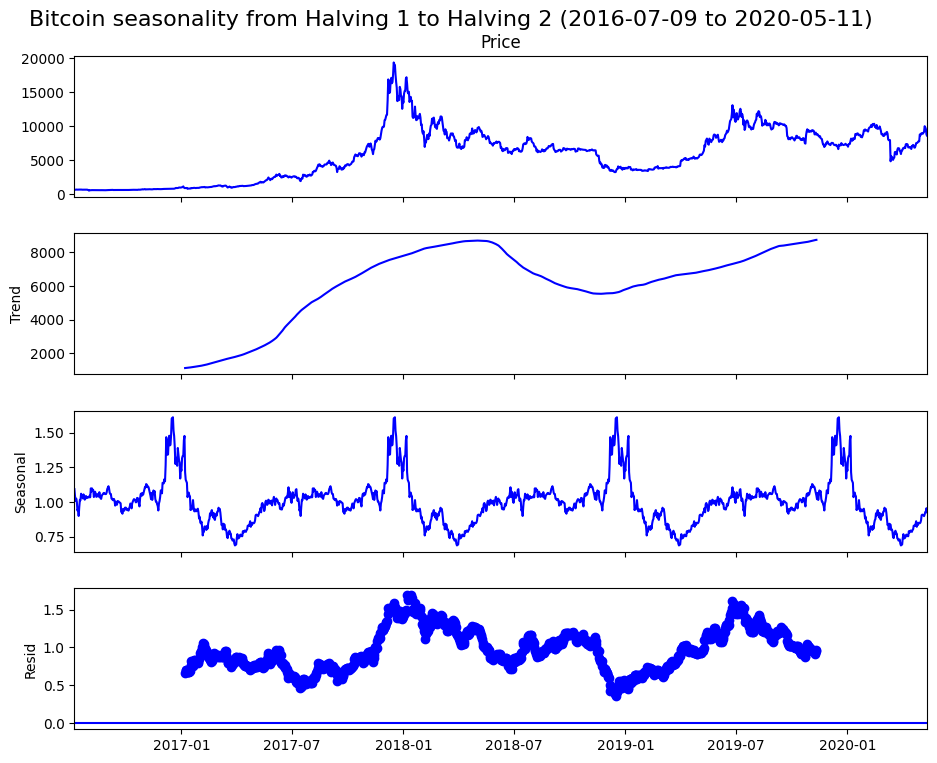

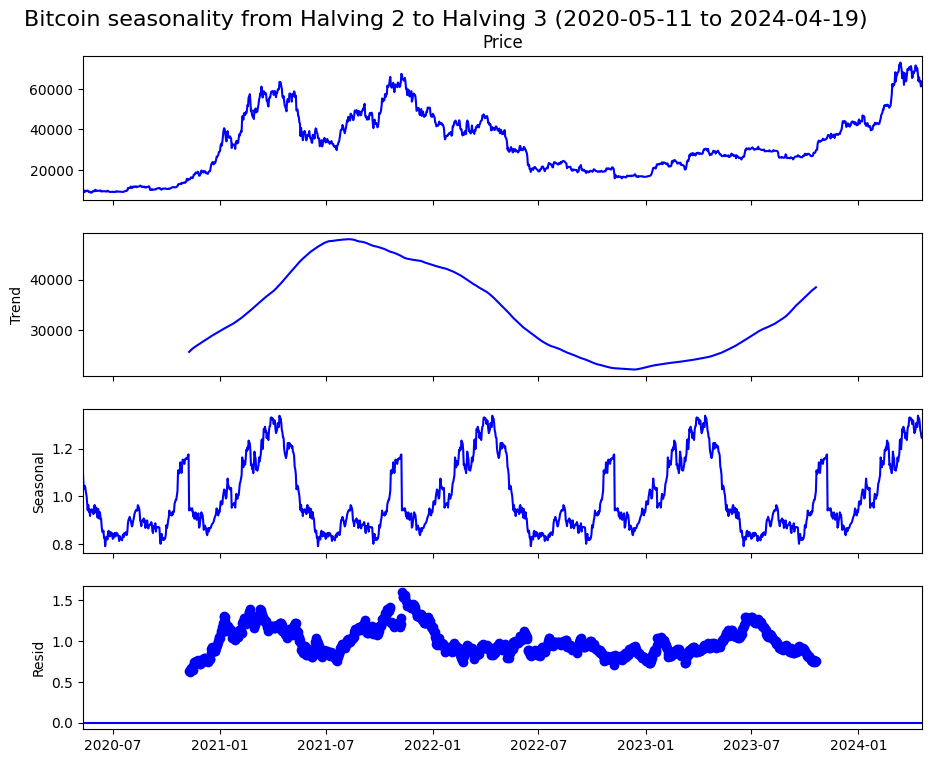

In [498]:
def plot_seasonality_for_period(data, title, period=365, plot_color='blue'):
    plot_decomposition(data['Price'], model='multiplicative', period=period, title=title, plot_color=plot_color)

for i, segment in enumerate(halving_data):
    title = f"Bitcoin seasonality from Halving {i+1} to Halving {i+2} ({segment.index[0].strftime('%Y-%m-%d')} to {segment.index[-1].strftime('%Y-%m-%d')})"
    plot_seasonality_for_period(segment, title=title, plot_color='blue')

#### ACF PACF

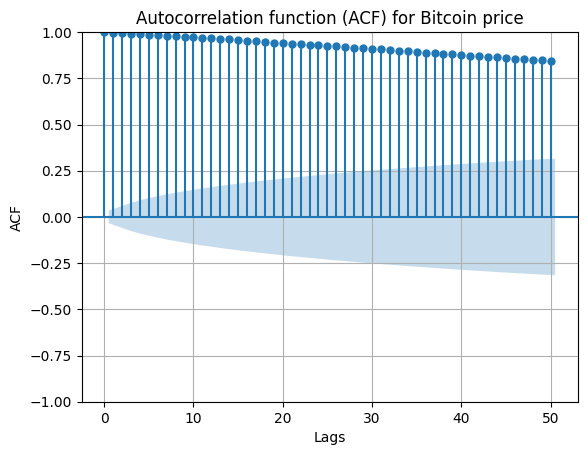

In [499]:
plot_acf(bitcoin['Price'], lags=50)
plt.title('Autocorrelation function (ACF) for Bitcoin price')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.grid(True)
plt.show()

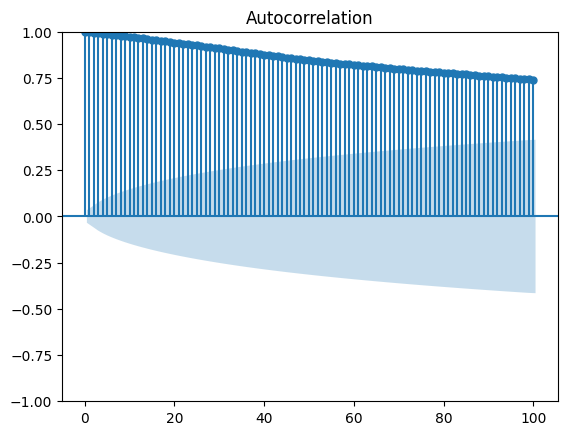

In [500]:
plot_acf(bitcoin['Price'], lags=100)
plt.show()

The Autocorrelation plot for the data is:


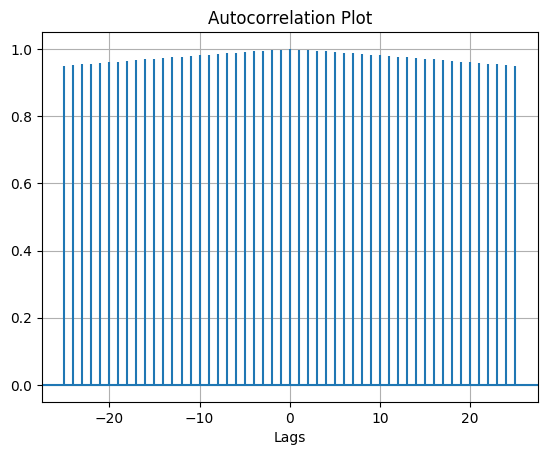

In [501]:
plt.title("Autocorrelation Plot") 
plt.xlabel("Lags") 
plt.acorr(bitcoin["Price"], maxlags = 25) 
print("The Autocorrelation plot for the data is:")
plt.grid(True)
 
plt.show() 

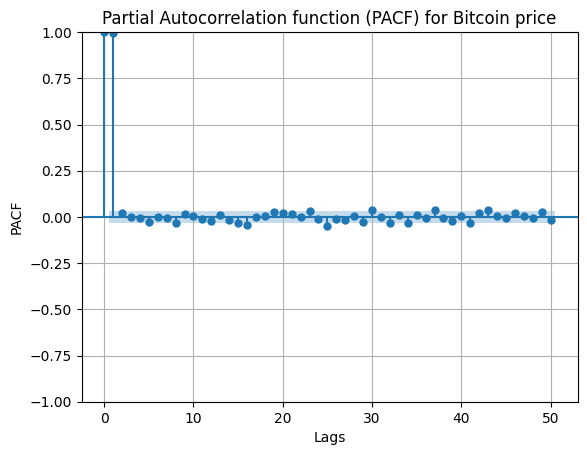

In [502]:
plot_pacf(bitcoin['Price'], lags=50)
plt.title('Partial Autocorrelation function (PACF) for Bitcoin price')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.grid(True)
plt.show()

#### Prophet

In [503]:
df = bitcoin[['Price']].reset_index()
df.rename(columns={'Date': 'ds', 'Price': 'y'}, inplace=True)
df

ds        y
0    2016-01-02    433.7
1    2016-01-03    430.7
2    2016-01-04    433.3
3    2016-01-05    431.2
4    2016-01-06    430.8
...         ...      ...
3283 2024-12-28  95284.5
3284 2024-12-29  93716.3
3285 2024-12-30  92779.8
3286 2024-12-31  93557.2
3287 2025-01-01  94560.2

[3288 rows x 2 columns]

In [504]:
df['ds'] = pd.to_datetime(df['ds'])
model = Prophet()
model.fit(df)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# 'yhat' represents the predicted values, 'yhat_lower' and 'yhat_upper' are the confidence intervals
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


20:40:13 - cmdstanpy - INFO - Chain [1] start processing
20:40:14 - cmdstanpy - INFO - Chain [1] done processing


ds          yhat    yhat_lower    yhat_upper
0    2016-01-02    -53.705306  -6058.114012   6304.846363
1    2016-01-03    -87.010155  -6414.686068   6503.444901
2    2016-01-04    -78.128458  -5885.129297   6300.170504
3    2016-01-05   -179.375532  -6374.839546   5943.051346
4    2016-01-06   -173.669986  -6433.562680   5849.807652
...         ...           ...           ...           ...
3313 2025-01-27  85890.016499  79857.830245  92515.474480
3314 2025-01-28  85989.799206  79371.782578  92324.937467
3315 2025-01-29  86220.767850  80188.876733  92431.350432
3316 2025-01-30  86300.755330  79800.397316  93075.232874
3317 2025-01-31  86517.913202  80648.674099  93094.002576

[3318 rows x 4 columns]

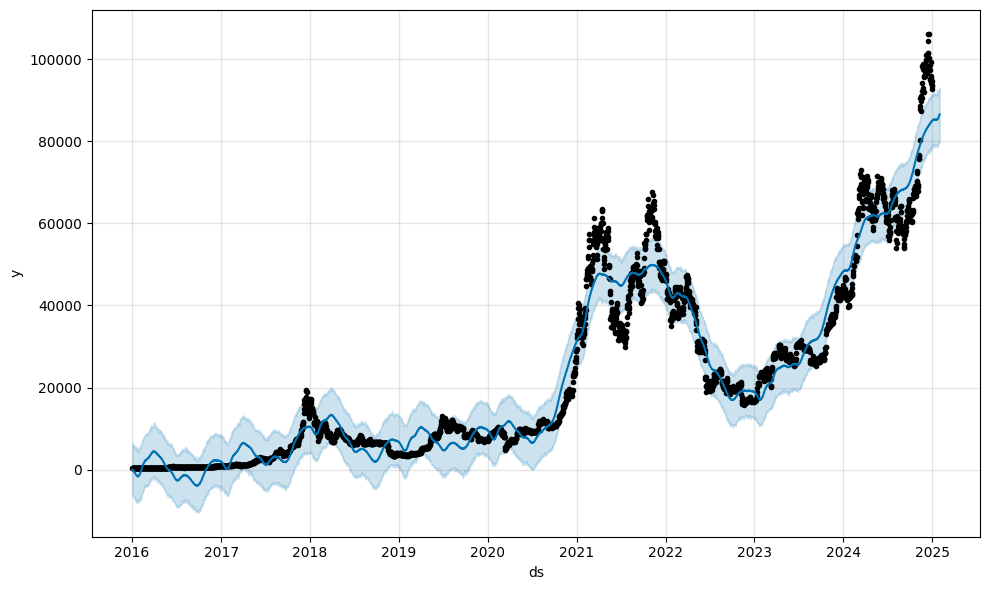

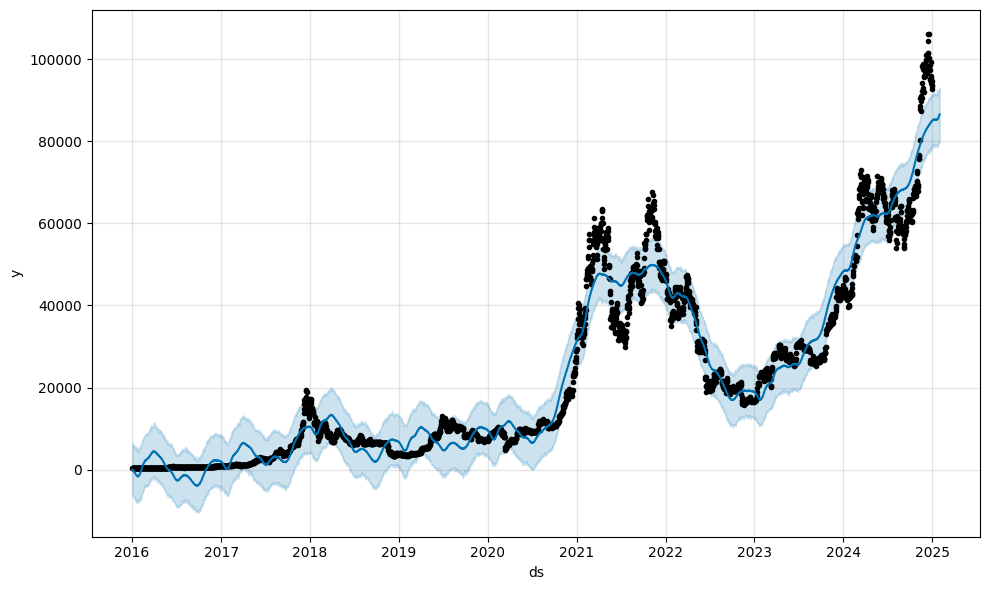

In [505]:
model.plot(forecast)

#### Random Forest

In [506]:
dataset = bitcoin.copy()

In [507]:
tstart = "2016-01-01"
tend = "2022-07-01"

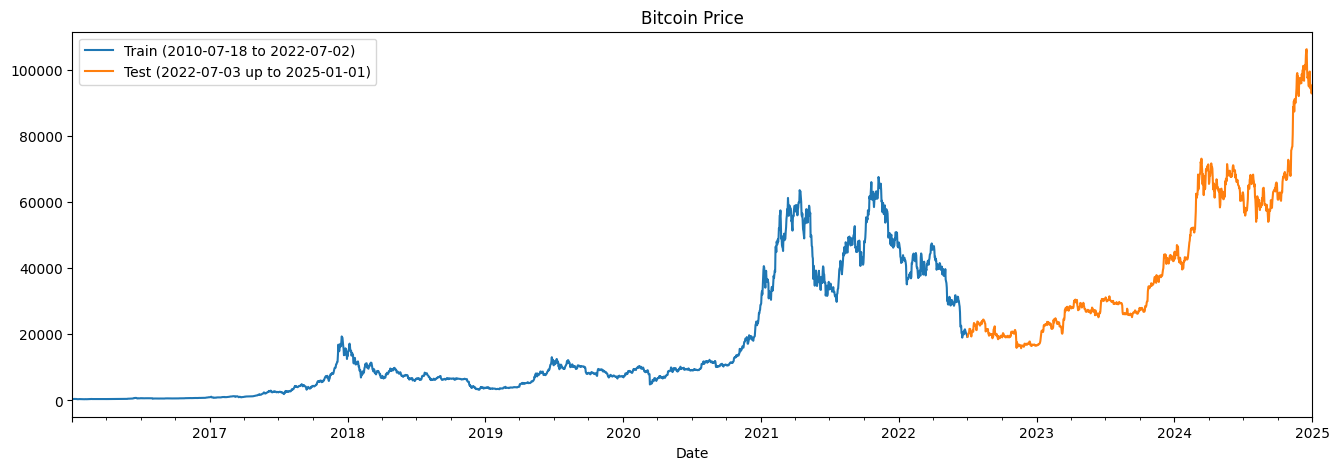

In [508]:
def train_test_plot(dataset, tstart, tend):
    tend_next = pd.to_datetime(tend) + pd.Timedelta(days=1)

    dataset.loc[tstart:tend, "Price"].plot(figsize=(16, 5), legend=True)
    dataset.loc[tend_next:, "Price"].plot(figsize=(16, 5), legend=True)

    plt.legend([f"Train (2010-07-18 to {tend_next.date()})", f"Test ({tend_next.date() + pd.Timedelta(days=1)} up to 2025-01-01)"])
    plt.title("Bitcoin Price")
    plt.show()

train_test_plot(dataset, tstart, tend)

In [509]:
def train_test_split(dataset, tstart, tend):
    tend_next = pd.to_datetime(tend) + pd.Timedelta(days=1)

    train = dataset.loc[tstart:tend, "Price"].values
    test = dataset.loc[tend_next:, "Price"].values
    return train, test

training_set, test_set = train_test_split(dataset, tstart, tend)

In [510]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [511]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 60
features = 1


In [512]:
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [522]:
# Flatten the training data for Random Forest (2D)
X_train_rf = X_train.reshape(X_train.shape[0], -1)
y_train_flat = y_train.ravel()


In [523]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=1)
rf_model.fit(X_train_rf, y_train_flat)

RandomForestRegressor(max_depth=20)

In [524]:
dataset_total = dataset.loc[:, "Price"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)
X_test, y_test = split_sequence(inputs, n_steps)

In [526]:
X_test_rf = X_test.reshape(X_test.shape[0], -1)

In [527]:
predicted_stock_price_rf = rf_model.predict(X_test_rf)

In [528]:
predicted_stock_price_rf = sc.inverse_transform(predicted_stock_price_rf.reshape(-1, 1))

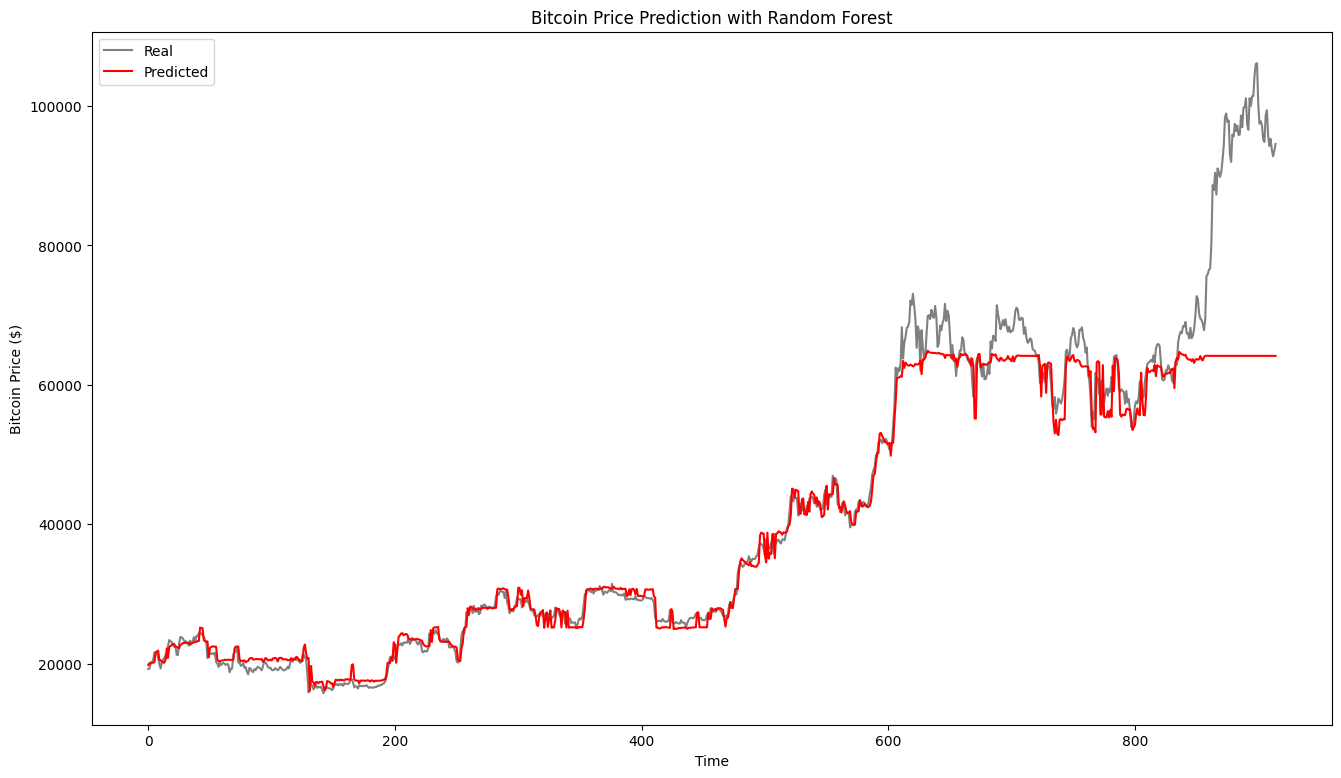

In [529]:
def plot_predictions(test, predicted):
    plt.figure(figsize=(16, 9))
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Bitcoin Price Prediction with Random Forest")
    plt.xlabel("Time")
    plt.ylabel("Bitcoin Price ($)")
    plt.legend()
    plt.show()

plot_predictions(test_set, predicted_stock_price_rf)

In [530]:
def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print(f"The root mean squared error is {rmse:.2f}.")

return_rmse(test_set, predicted_stock_price_rf)

The root mean squared error is 8073.91.


In [535]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],  
    'min_samples_leaf': [1, 2, 4]
}

In [536]:
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_rf, y_train_flat)
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [539]:
best_rf_model = grid_search.best_estimator_
predicted_stock_price_rf = best_rf_model.predict(X_test_rf)
predicted_stock_price_rf = sc.inverse_transform(predicted_stock_price_rf.reshape(-1, 1))

# Evaluate the model with RMSE
rmse = np.sqrt(mean_squared_error(test_set, predicted_stock_price_rf))
print(f"Root Mean Squared Error: {rmse:.2f}")

Root Mean Squared Error: 7990.70


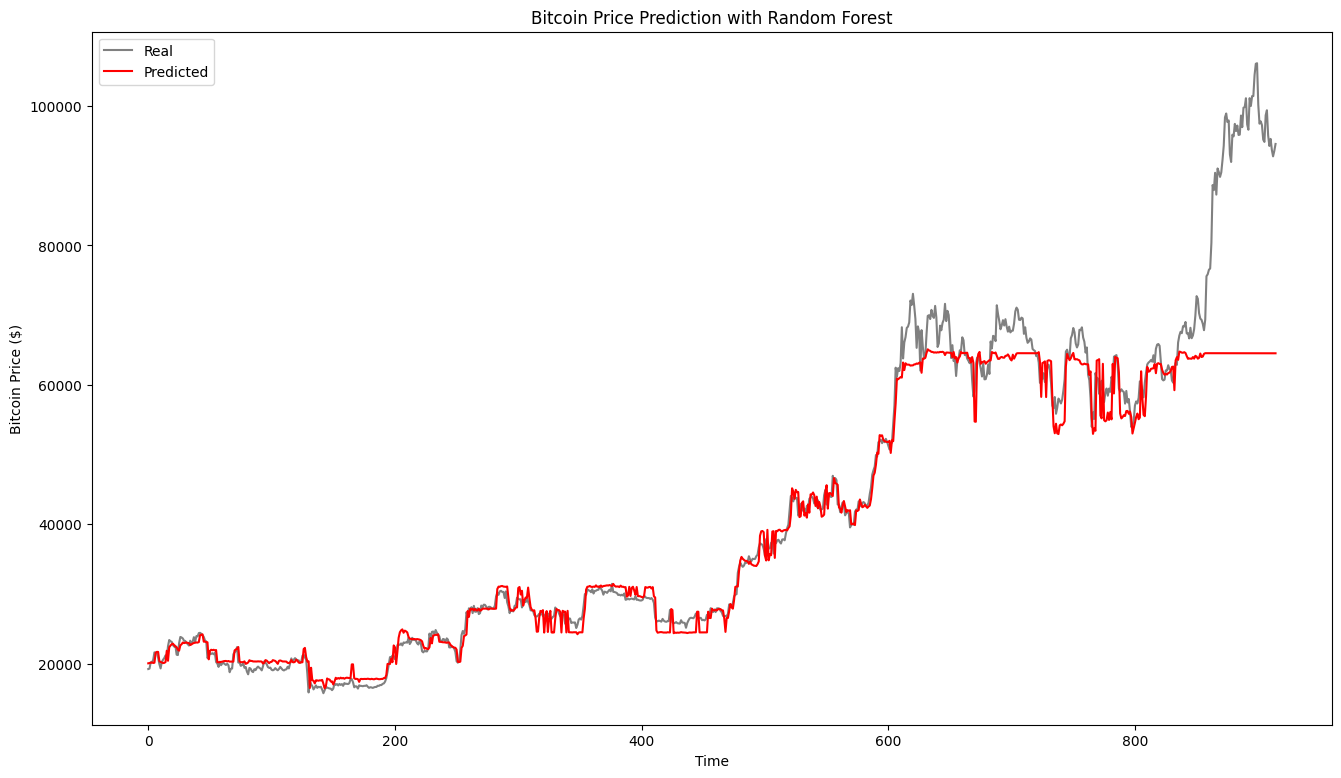

In [540]:
plot_predictions(test_set, predicted_stock_price_rf)